## SECTION I. Linear Regression

We will implement a linear regression model to fit a curve to some data. Since the data is nonlinear, we will implement polynomial regression and use ridge regression to implement the best possible fit.

### STEP1. Load Data and Visualize

Let us load a dataset of points $(x,y)$. As a first step, let's import the required libraries followed by the dataset.

In [1]:
import numpy as np
from datasets import ridge_reg_data

# Libraries for evaluating the solution
import pytest
import numpy.testing as npt
import random
random.seed(1)
np.random.seed(1)

train_X, train_Y, test_X, test_Y = ridge_reg_data() # Pre-defined function for loading the dataset
train_Y = train_Y.reshape(-1,1) # reshaping from (m,) -> (m,1)
test_Y = test_Y.reshape(-1,1)
print('train_X.shape is ', train_X.shape)
print('train_Y.shape is ', train_Y.shape)
print('test_X.shape is ', test_X.shape)
print('test_Y.shape is ', test_Y.shape)

train_X.shape is  (300, 1)
train_Y.shape is  (300, 1)
test_X.shape is  (200, 1)
test_Y.shape is  (200, 1)


### Visualize Data

The dataset is split into train and test sets. The train set consists of 300 samples and the test set consists of 200 samples. We will use scatter plot to visualize the relationship between the '$x$' and '$y$'. Lets visualize the data using the scatter plot from [matplotlib](https://matplotlib.org/).

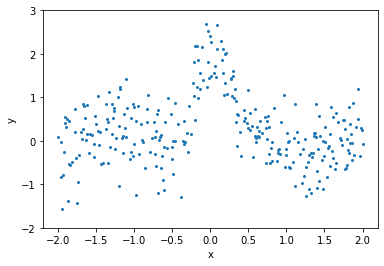

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(train_X,train_Y,marker='o',s=4)
plt.ylim(-2, 3)
plt.xlabel('x')
plt.ylabel('y');

### STEP3. Polynomial Transformation

Using the train data we hope to learn a relationship mapping $x$ to $y$. We can evaluate this mapping using the test data. Linear regression will try to fit a straight line (linear relation) mapping $x$ to $y$. However, we observe the $x$ and $y$ do not have a linear relationship. A straight line will not be a good fit. We need a non-linear mapping (curve) between $x$ and $y$. 

The solution is opting for nonlinear regression, which can be achieved by transforming the scalar $x$ to a high dimension sample and performing linear regression with the transformed data. We can transform $x$ into a $d$ dimensional vector ($d \geq 2$) in order to perform nonlinear regression. For example, $d = 5$ transforms $x$ into a $(d+1)$ dimension vector $[1,x,x^2,x^3,x^4,x^5]^\top$, where $x^k$ is $x$ raised to $k$. In vectorized notation, the dataset $X$ is transformed to $\Phi(X)$ of  dimension $m \times (d+1)$, where $m$ is the number of samples. 

Every scalar $x$ is converted into a $(d+1)$ dimension vector, $[1,x_1,x_2,x_3,\ldots,x_d]^\top$. We can now perform linear regression in $(d+1)$ dimensions.
\begin{equation*}
y = \Phi(x)\boldsymbol{\theta} = \theta_0 + x_1\theta_1 + ... + x_{d-1}\theta_{d-1} + x_d\theta_d\\
\end{equation*}
In the above equation, $y$ is the target variable, $\boldsymbol{\theta} = [\theta_{0},.., \theta_{d}]^\top$ are the parameters/weights of the model, $\Phi(x) = [1,x_{1},.., x_{d}]$ is the transformed data point in the row vector format, where $x_k$ is the $k^{th}$ component. 
    
In the vectorized notation, the linear regression for $m$ samples is written as  $\hat{Y} = \Phi(X)\boldsymbol{\theta}$, where $\Phi(X)$ has the data points as row vectors and is of dimensions $m \times (d+1)$,

\begin{align}
\begin{bmatrix} \hat{y}^{(1)} \\ 
\hat{y}^{(2)}\\
\vdots\\ 
\hat{y}^{(m)}
\end{bmatrix} = 
\begin{bmatrix} 1 & x^{(1)}_1 & x^{(1)}_2  & \ldots & x^{(1)}_d\\ 
1 & x^{(2)}_1 & x^{(2)}_2  & \ldots & x^{(2)}_d\\  
\vdots & \vdots & \vdots & \vdots & \vdots\\ 
1 & x^{(m)}_1 & x^{(m)}_2  & \ldots & x^{(m)}_d\\ 
\end{bmatrix}
\begin{bmatrix} \theta_0 \\ 
\theta_1\\ 
\vdots \\ 
\theta_d\\ 
\end{bmatrix}
\end{align}

$X$ - is the Design matrix of dimension $m \times (d+1) $, where $m$ is the number of samples and $d$ is the degree of the polynomial that we are trying to fit. The first column of 1's in the design matrix will account for the bias , resulting in $d+1$ dimensions <br>

$Y$ - Vector of the prediction labels of dimension $m \times 1 $.
Lets implement a function to achieve this transformation.

In [3]:
def poly_transform(X,d):
    '''
    Function to transform scalar values into (d+1)-dimension vectors. 
    Each scalar value x is transformed a vector [1,x,x^2,x^3, ... x^d]. 
    
    Inputs:
        X: vector of m scalar inputs od shape (m, 1) where each row is a scalar input x
        d: number of dimensions
        
    Outputs:
        Phi: Transformed matrix of shape (m, (d+1)) 
    '''
    Phi = np.ones((X.shape[0],1))
    for i in range(1,d+1):
        col = np.power(X,i)
        Phi = np.hstack([Phi,col])
    return Phi

### STEP4: Defining the objective function

Let us define the objective function that will be optimized by the linear regression model.
    \begin{equation*}
    L\big(\Phi(X),Y,\theta\big) = \big(Y-\Phi(X)\boldsymbol{\theta}\big)^\top \big(Y-\Phi(X)\boldsymbol{\theta}\big)
    \end{equation*}

Here, $\Phi(X)$ is the design matrix of dimensions (m \times (d+1)) and $Y$ is the $m$ dimension vector of labels. 
$\theta$ is the $(d+1)$ dimension vector of weight parameters.

In [4]:
def lin_reg_obj(Y,Phi,theta):
    '''
    Objective function to estimate loss for the linear regression model.
    Inputs:
        Phi: Design matrix of dimensions (m, (d+1))
        Y: ground truth labels of dimensions (m, 1)
        theta: Parameters of linear regression of dimensions ((d+1),1)
        
    outputs:
        loss: scalar loss 
    '''    
    loss = np.dot((Y - np.dot(Phi,theta)).T,(Y - np.dot(Phi,theta)))

    
    return loss



### STEP5: Closed Form Solution to find the best value of theta

Let us define a closed form solution to the objective function. Feel free to revisit the lecture to review the topic.
Closed form solution is given by,

\begin{equation*}
\theta = \big(\Phi(X)^\top\Phi(X)\big)^{-1}\Phi(X)^\top Y
\end{equation*}

Here $\Phi(X)$ is the $(m \times (d+1))$ dimension design matrix obtained using *poly_transform* function defined earlier and $Y$ are the ground truth labels of dimensions $(m \times 1)$. 


In [5]:
#Closed form solution
def lin_reg_fit(Phi_X,Y):
    '''
    A function to estimate the linear regression model parameters using the closed form solution.
    Inputs:
        Phi_X: Design matrix of dimensions (m, (d+1))
        Y: ground truth labels of dimensions (m, 1)
         
    Outputs:
        theta: Parameters of linear regression of dimensions ((d+1),1)
    '''
    theta = np.dot(np.linalg.inv(np.dot(Phi_X.T,Phi_X)),np.dot(Phi_X.T, Y))

    return theta

### STEP6: Evaluating the linear regression model

We will evaluate the goodness of our linear regression model using root mean square error. This compares the difference between the estimate Y-labels and the groundth truth Y-labels. The smaller the RMSE value, better is the fit. 
1. RMSE (Root Mean Squared Error)
\begin{equation*}
\sqrt{\frac{1}{m}\sum_{i=1}^{m}(y\_pred^{(i)} - y^{(i)})^{2} }
\end{equation*}



In [6]:
def get_rmse(Y_pred,Y):
    '''
    function to evaluate the goodness of the linear regression model.
    
    Inputs:
        Y_pred: estimated labels of dimensions (m, 1)
        Y: ground truth labels of dimensions (m, 1)
        
    Outputs:
        rmse: root means square error
    '''
    m = Y.shape[0]
    rmse = np.sqrt(1.0/m*np.dot((Y_pred-Y).T,(Y_pred-Y)))
    return rmse

Let's visualize the nonlinear regression fit and the RMSE evaluation error on the test data

Train RMSE =  [[0.51363408]]
Test RMSE =  [[0.50375198]]


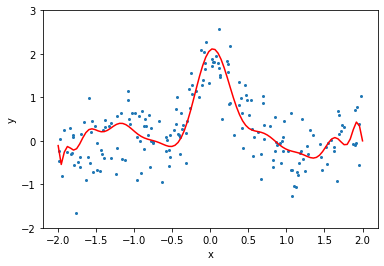

In [7]:
d = 20
Phi_X_tr = poly_transform(train_X,d)
theta = lin_reg_fit(Phi_X_tr,train_Y)
#Estimate the prediction on the train data
Y_Pred_tr = np.dot(Phi_X_tr,theta)
rmse = get_rmse(Y_Pred_tr,train_Y)
print('Train RMSE = ', rmse)

#Perform the same transform on the test data
Phi_X_ts = poly_transform(test_X,d)
#Estimate the prediction on the test data
Y_Pred_ts = np.dot(Phi_X_ts,theta)
#Evaluate the goodness of the fit
rmse = get_rmse(Y_Pred_ts,test_Y)
print('Test RMSE = ', rmse)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(test_X,test_Y,marker='o',s=4)
# Sampling more points to plot a smooth curve
px = np.linspace(-2,2,100).reshape(-1,1)
PX = poly_transform(px,d)
py = np.dot(PX,theta)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 3)
plt.plot(px,py,color='red');

## SECTION II. Ridge Regression 

The degree of the polynomial regression is $d=10$. Even though the curve appears to be smooth, it may be fitting to the noise. We will use Ridge Regression to get a smoother fit and avoid-overfitting. Recall the ridge regression objective form:

\begin{equation*}
    L\big(\Phi(X),Y,\theta, \lambda\big) = \big(Y-\Phi(X)\boldsymbol{\theta}\big)^\top \big(Y-\Phi(X)\boldsymbol{\theta}\big) + \lambda^2\boldsymbol{\theta}^\top\boldsymbol{\theta}
\end{equation*}
where, $\lambda\geq 0$ is the regularization parameter. Larger the value of $\lambda$, the more smooth the curve. The closed form solution to the objective is give by: 

\begin{equation*}
\theta = \big(\Phi(X)^\top\Phi(X) + \lambda^2I_d \big)^{-1}\Phi(X)^\top Y
\end{equation*}

Here, $I_d$ is the identity matrix of dimensions $((d+1) \times (d+1))$, $\Phi(X)$ is the $(m \times (d+1))$ dimension design matrix obtained using *poly_transform* function defined earlier and $Y$ are the ground truth labels of dimensions $(m \times 1)$. 

### STEP1: Ridge Regression Closed Form Solution

Similar to Linear regression, lets implement the closed form solution to ridge regression.

In [8]:
def ridge_reg_fit(Phi_X,Y,lamb_d):
    '''
    A function to estimate the ridge regression model parameters using the closed form solution.
    Inputs:
        Phi_X: Design matrix of dimensions (m, (d+1))
        Y: ground truth labels of dimensions (m, 1)
        lamb_d: regularization parameter
         
    Outputs:
        theta: Parameters of linear regression of dimensions ((d+1),1)
    '''
    #Step 1: get the dimension dplus1 using Phi_X to create the identity matrix $I_d$
    #Step 2: Estimate the closed form solution similar to *linear_reg_fit* but now includethe lamb_d**2*I_d term
    # your code here
    d = Phi_X.shape[1]

    theta = np.dot(np.linalg.inv(np.dot(Phi_X.T,Phi_X) + lamb_d**2*np.eye(d)),np.dot(Phi_X.T, Y))
    return theta

### STEP2: Cross Validation to Estimate ($\lambda$)

In order to avoid overfitting when using a high degree polynomial, we have used **ridge regression**. We now need to estimate the optimal value of $\lambda$ using **cross-validation**.

We will obtain a generic value of $\lambda$ using the entire training dataset to validate. We will employ the method of **$k$-fold cross validation**, where we split the training data into $k$ non-overlapping random subsets. In every cycle, for a given value of $\lambda$, $(k-1)$ subsets are used for training the ridge regression model and the remaining subset is used for evaluating the goodness of the fit. We estimate the average goodness of the fit across all the subsets and select the $lambda$ that results in the best fit.


![K-fold cross validation](images/kfold.png)

It is easier to shuffle the index and slice the training into required number of segments, than processing the complete dataset. The below function **k_val_ind$()$** returns a 2D list of indices by spliting the datapoints into  '$k\_fold$'  sets

Refer the following documentation for splitting and shuffling:

- https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html


In [9]:
def k_val_ind(index,k_fold,seed=1):
    '''
    Function to split the data into k folds for cross validation. Returns the indices of the data points 
    belonging to every split.
    
    Inputs:
        index: all the indices of the training
        k_fold: number of folds to split the data into
    
    Outputs:
        k_set: list of arrays with indices
    ''' 
    np.random.seed(seed)
    np.random.shuffle(index) # Shuffle the indices
    k_set = np.split(index,k_fold) # Split the indices into 'k_fold' 
    return k_set

### K- Fold Cross Validation

Let's now implement $k$-fold cross validation.

In [10]:
def k_fold_cv(k_fold,train_X,train_Y,lamb_d,d):
    '''
    Function to implement k-fold cross validation.
    Inputs:
        k_fold: number of validation subsests
        train_X: training data of dimensions (m, 1) 
        train_Y: ground truth training labels
        lamb_d: ridge regularization lambda parameter
        d: polynomial degree
        
    Outputs:
        rmse_list: list of root mean square errors (RMSE) for k_folds 
    '''
    index = np.arange(train_X.shape[0]) # indices of the training data
    
    k_set = k_val_ind(index,k_fold) # pre-defined function to shuffle and split indices 
    Phi_X = poly_transform(train_X, d) # transform all the data to (m,(d+1)) dimensions
    rmse_list = [] 
    #Note: Eg. train_X[ind] -> validation set, train_X[~ind] -> training set 
    # Write your answer inside the 'for' loop    
    for i in range(k_fold):
        ind = np.zeros(train_X.shape[0], dtype=bool) # binary mask
        ind[k_set[i]] = True # validation portion is indicated

        # Note: Phi_X[~ind,:] is training subset and Phi_X[ind,:] is validation subset. Similary for the train and validation labels.
        # Step 1: Estimate the theta parameter using ridge_reg_fit with the training subset, training labels and lamb_d
        # Step 2: Estimate the prediction Y_pred over the validation as a dot product over Phi_X[ind,:] and theta
        # Step 3: use 'get_rmse' function to determine rmse using Y_pred and train_Y[ind]
        
        theta = ridge_reg_fit(Phi_X[~ind,:], train_Y[~ind],lamb_d)
        Y_pred = np.dot(Phi_X[ind,:],theta)
        rmse = get_rmse(Y_pred,train_Y[ind])
        
        rmse_list.append(rmse)
    return rmse_list

Let us select the value of $\lambda$ that provides the lowest error based on RMSE returned by the 'k_fold_cv' function.

In this example, we will choose the best value of $\lambda$ among 6 values.

In [11]:
k_fold = 5 
l_range = [0,1e-3,1e-2,1e-1,1,10] # The set of lamb_d parameters used for validation.
th = float('inf')
for lamb_d in l_range:     
    print('lambda:'+str(lamb_d))
    rmse = k_fold_cv(k_fold,train_X,train_Y,lamb_d,d)
    print("RMSE: ",rmse)
    print("*************")
    mean_rmse = np.mean(rmse)
    if mean_rmse<th:
        th = mean_rmse
        l_best = lamb_d

print("Best value for the regularization parameter(lamb_d):",l_best)

lambda:0
RMSE:  [array([[0.90118381]]), array([[0.59950092]]), array([[0.48898813]]), array([[0.57352291]]), array([[0.57786825]])]
*************
lambda:0.001
RMSE:  [array([[0.92587068]]), array([[0.6019134]]), array([[0.48866102]]), array([[0.5708622]]), array([[0.5784616]])]
*************
lambda:0.01
RMSE:  [array([[1.04589527]]), array([[0.62518064]]), array([[0.49331885]]), array([[0.5570598]]), array([[0.58995988]])]
*************
lambda:0.1
RMSE:  [array([[0.82614745]]), array([[0.64652484]]), array([[0.49033218]]), array([[0.56609505]]), array([[0.59456686]])]
*************
lambda:1
RMSE:  [array([[0.67996651]]), array([[0.68866935]]), array([[0.56473578]]), array([[0.63930751]]), array([[0.64703292]])]
*************
lambda:10
RMSE:  [array([[0.7335261]]), array([[0.69930692]]), array([[0.75561325]]), array([[0.79926087]]), array([[0.8199075]])]
*************
Best value for the regularization parameter(lamb_d): 0.1


### STEP3: Evaluation on the Test Set

As discussed in previous section, we will present the final evaluation of the model based on the test set.

In [12]:
lamb_d = l_best

# Step 1: Create Phi_X using 'poly_transform(.)' on the train_X and d=20
# Step 2: Estimate theta using ridge_reg_fit(.) with Phi_X, train_Y and the best lambda
# Step 3: Create Phi_X_test using 'poly_transform(.)' on the test_X and d=20
# Step 4: Estimate the Y_Pred for the test data using Phi_X_test and theta
# Step 5: Estimate rmse using get_rmse(.) on the Y_Pred and test_Y 

Phi_X = poly_transform(train_X,20)
theta = ridge_reg_fit(Phi_X,train_Y,lamb_d)
Phi_X_test = poly_transform(test_X,20)
Y_pred = np.dot(Phi_X_test,theta)
rmse = get_rmse(Y_pred,test_Y)

print("RMSE on test set is "+str(rmse))

RMSE on test set is [[0.49850097]]


Let's visualize the model's prediction on the test data set.

Test RMSE =  [[0.49850097]]


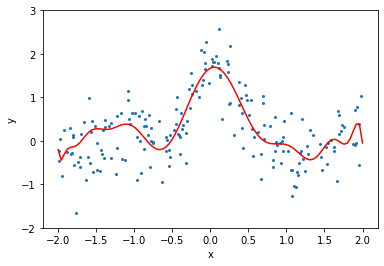

In [13]:
print('Test RMSE = ', rmse)

%matplotlib inline
plt.scatter(test_X,test_Y,marker='o',s=4)
# Sampling more points to plot a smooth curve
px = np.linspace(-2,2,100).reshape(-1,1)
PX = poly_transform(px,d)
py = np.dot(PX,theta)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 3)
plt.plot(px,py,color='red');